In [1]:
import gym

import qwertyenv

In [2]:
env = gym.make('qwertyenv/BlackJack-v0')

In [3]:
obs, info = env.reset()

In [4]:
env.render()

Useful Ace
Current sum:  18
Dealer showing:  A


In [5]:
episodes = 5

for episode in range(episodes):
    print(f"Episode {episode}\n")
    obs = env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        print("action", action, "->", "reward", reward, "done", done, info, "\n")
        if done:
            break
    print("-" * 50)

Episode 0

Useful Ace
Current sum:  14
Dealer showing:  A
action 0 -> reward 0 done False {'new card': 4} 

Useful Ace
Current sum:  18
Dealer showing:  A
action 1 -> reward -1 done True {'dealer sum': 19} 

--------------------------------------------------
Episode 1

Useful Ace
Current sum:  21
Dealer showing:  10
action 1 -> reward 1 done True {'dealer sum': 20} 

--------------------------------------------------
Episode 2

No useful Ace
Current sum:  17
Dealer showing:  9
action 0 -> reward 0 done False {'new card': 2} 

No useful Ace
Current sum:  19
Dealer showing:  9
action 0 -> reward -1 done True {'new card': 4} 

--------------------------------------------------
Episode 3

Useful Ace
Current sum:  11
Dealer showing:  7
action 0 -> reward 0 done False {'new card': 9} 

Useful Ace
Current sum:  20
Dealer showing:  7
action 1 -> reward 0 done True {'dealer sum': 20} 

--------------------------------------------------
Episode 4

No useful Ace
Current sum:  16
Dealer showing:  

In [6]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

def MC_exploring_starts(episodes):
    # our initial, arbitrary, policy is to stick with 20 or 21 but otherwise to hit
    policy = dict()
    for player_sum in range(11): # 0 .. 10 -> 11 .. 21
        for dealer_showing in range(10):
            policy[0, player_sum, dealer_showing] = 0 if player_sum < 9 else 1 # sticks on 20 or 21
            policy[1, player_sum, dealer_showing] = 0 if player_sum < 9 else 1 # sticks on 20 or 21
    state_action_value = dict()
    returns = defaultdict(list)
    for i in range(episodes):
        start, _ = env.reset()
        start_action = env.action_space.sample()
        # generating the episode that starts with our randomly chosen start and action
        s = start
        a = start_action
        current_episode = []
        while True:
            obs, reward, done, info = env.step(a)
            current_episode.append((s, a, reward, obs))
            if done:
                break
            s = obs                       
            a = policy[s['player_useful_Ace'], s['player_sum'], s['dealer_shown_card']]
        # update wrt the episode
        seen = set()
        for entry in current_episode:
            s, a, _, _ = entry
            s = (s['player_useful_Ace'], s['player_sum'], s['dealer_shown_card'])
            if (s, a) in seen:
                entry[1] = -1 # mark as don't update
            else:
                seen.add((s, a))
        gamma = 1 # discount factor
        g = 0
        for entry in reversed(current_episode):
            s, a, reward, _ = entry
            s = (s['player_useful_Ace'], s['player_sum'], s['dealer_shown_card'])
            g += reward
            if a > -1: # above we've used -1 to mark not to use for update
                returns[s, a].append(g)
                state_action_value[s, a] = np.mean(returns[s, a])
                policy[s] = np.argmax([state_action_value.get((s, action), 0) for action in [0, 1]])
    state_value = defaultdict(list)
    for k, v in state_action_value.items():
        s, a = k
        state_value[s].append(v)
    state_value = {
        k: np.max(v)
        for k, v in state_value.items() 
    }
    return policy, state_value

In [7]:
policy, state_value = MC_exploring_starts(1000)

In [8]:
def plot_policy(policy):
    m = np.zeros(shape=(11, 10), dtype=bool)
    for useful_ace in [0, 1]:
        print('useful_ace', 'Yes' if useful_ace == 1 else 'No')
        for player_sum in range(11):
            for dealer_showing in range(10):
                m[player_sum, dealer_showing] = policy[useful_ace, player_sum, dealer_showing] 
        fig = plt.figure()
        ax = fig.add_subplot(111)                
        msh = ax.matshow(m, interpolation="none")
        ax.set_ylim(-0.5, 10.5)
        ax.set_yticks(range(11))
        ax.set_xticks(range(10))
        ax.set_axisbelow(False)
        ax.set_yticklabels(list(map(lambda x: x + 11, range(11))))
        ax.set_ylabel('Player sum')
        ax.set_xticklabels(['A'] + list(map(str, range(2, 11))))
        ax.set_xlabel('Dealer showing')
        plt.gca().xaxis.tick_bottom()
        fig.colorbar(msh)
        plt.show()

useful_ace No


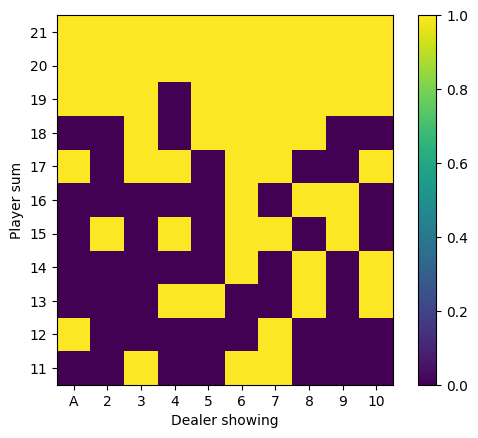

useful_ace Yes


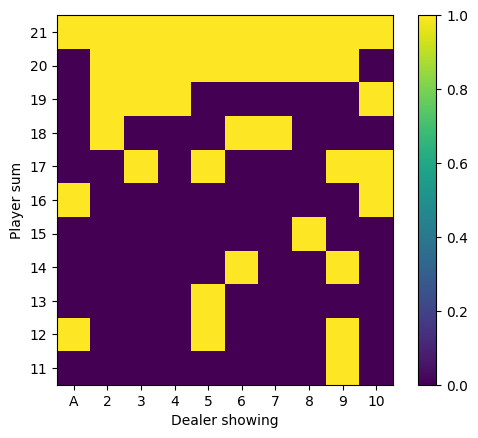

In [9]:
plot_policy(policy)

In [10]:
def plot_state_value(state_value):
    m = np.zeros(shape=(11, 10))
    for useful_ace in [0, 1]:
        print('useful_ace', 'Yes' if useful_ace == 1 else 'No')
        for player_sum in range(11):
            for dealer_showing in range(10):
                m[player_sum, dealer_showing] = state_value.get((useful_ace, player_sum, dealer_showing), None) 
        fig = plt.figure()
        ax = fig.add_subplot(111)                
        msh = ax.matshow(m, interpolation="none")
        ax.set_ylim(-0.5, 10.5)
        ax.set_yticks(range(11))
        ax.set_xticks(range(10))
        ax.set_axisbelow(False)
        # ax.set_yticklabels(map(lambda x: x + 11, range(10)))
        ax.set_yticklabels(list(map(lambda x: x + 11, range(11))))
        ax.set_ylabel('Player sum')        
        ax.set_xticklabels(['A'] + list(map(str, range(2, 11))))
        ax.set_xlabel('Dealer showing')        
        plt.gca().xaxis.tick_bottom()
        fig.colorbar(msh)
        plt.show()

useful_ace No


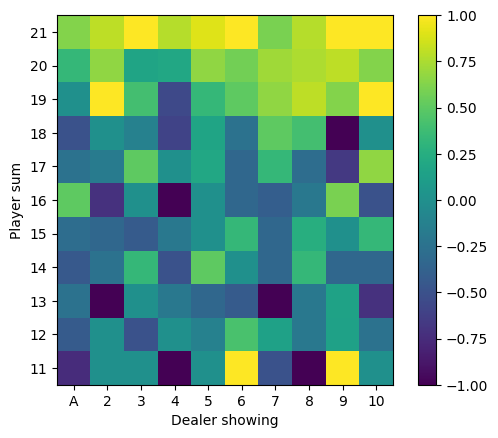

useful_ace Yes


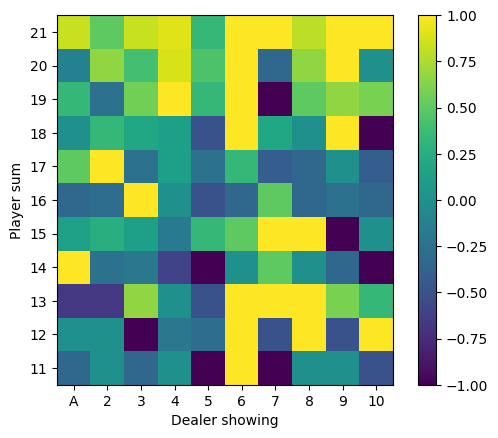

In [11]:
plot_state_value(state_value)